In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

import rasterio as rio
from rasterio.plot import reshape_as_image
from rasterio.windows import Window,from_bounds
import geopandas as gpd

import matplotlib.pyplot as plt

import os
from random import sample

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plt.style.use("bmh")

In [57]:
class LoadImageData(Dataset):
    def __init__(self,GEOJsonFile,S2Before,S2After,S1Now,S2Now, transform=None):
        # data loading
        self.geo = gpd.read_file(GEOJsonFile)
        self.S2N = S2Now
        self.S2B = S2Before
        self.S2A = S2After
        self.S1N = S1Now
        self.n_samples = len(self.geo)
        
        self.transform = transform
        
    def __len__(self):
        return self.n_samples

    def __getitem__(self,idx):
        _S2N = rio.open(self.S2N)
        _S2B = rio.open(self.S2B)
        _S2A = rio.open(self.S2A)
        _S1N = rio.open(self.S1N)
        
        
        minx,miny,maxx,maxy = self.geo.loc[idx, 'geometry'].bounds
        window = from_bounds(minx, miny, maxx, maxy, transform=_S2N.transform)
        
        self.S2B_img = np.moveaxis(_S2B.read(window=window ,resampling=0),0,-1)
        self.S2A_img = np.moveaxis(_S2A.read(window=window ,resampling=0),0,-1)
        self.S1N_img = np.moveaxis(_S1N.read(window=window ,resampling=0),0,-1)
        
        self.S2N_img = np.moveaxis(_S2N.read(window=window ,resampling=0),0,-1)
        
        if self.transform is not None:
            _transformedS2B = self.transform(image = self.S2B_img)
            _transformedS2A = self.transform(image = self.S2A_img)
            _transformedS1N = self.transform(image = self.S1N_img)
            
            _transformedS2N = self.transform(image = self.S2N_img)
            
            self.S2B_img = _transformedS2B["image"]
            self.S2A_img = _transformedS2A["image"]
            self.S1N_img = _transformedS1N["image"]
            
            self.S2N_img = _transformedS2N["image"]
            
            
        return self.S2B_img,self.S2A_img,self.S1N_img,self.S2N_img

In [58]:
!ls ../data

s1				   S2_B4328_10m_25072019.tif
S1_VH_VV_10m_25072019_aligned.tif  s2_cloud_mask.geojson
s2				   test_data.geojson
S2_B4328_10m_05072019.tif	   train_data.geojson
S2_B4328_10m_24082019.tif	   valid_data.geojson


In [64]:
train_transform = A.Compose([ToTensorV2()])

In [70]:
img = LoadImageData('../data/train_data.geojson',
                    '../data/S2_B4328_10m_05072019.tif',
                    '../data/S2_B4328_10m_24082019.tif',
                    '../data/S1_VH_VV_10m_25072019_aligned.tif',
                    '../data/S2_B4328_10m_25072019.tif',
                    transform=None)

In [71]:
img[0][3].shape

(64, 64, 4)

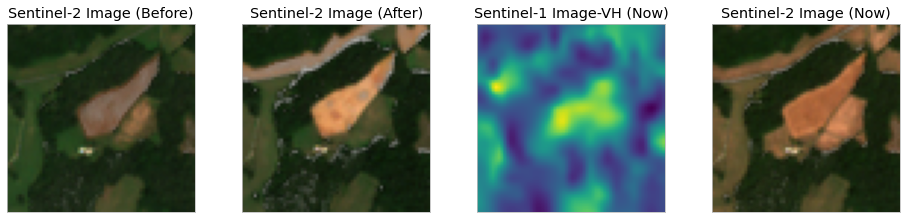

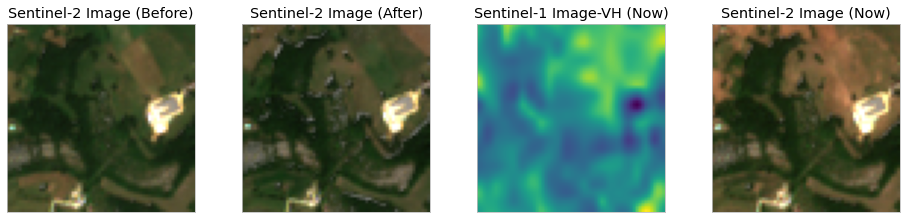

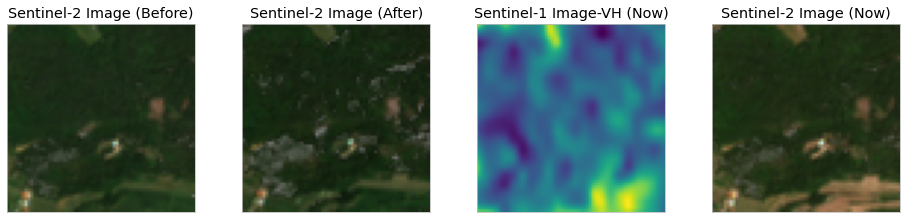

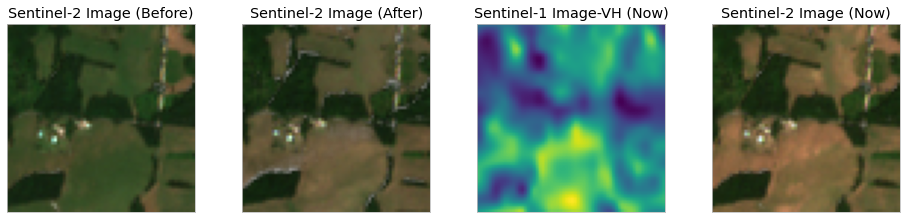

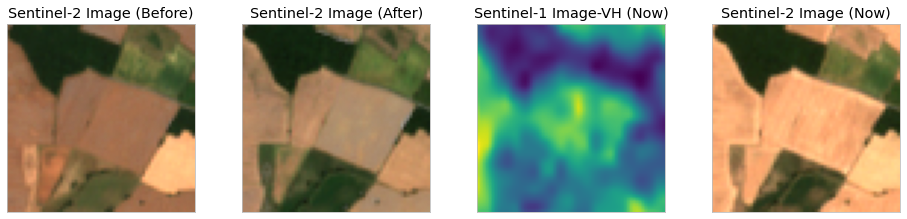

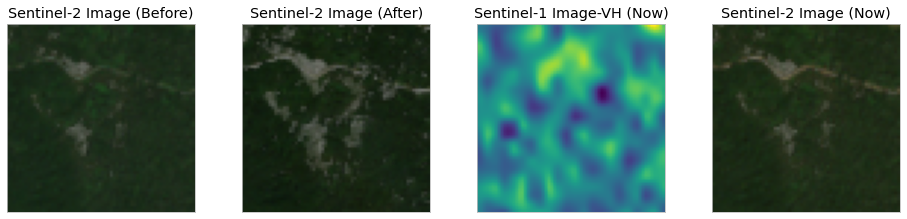

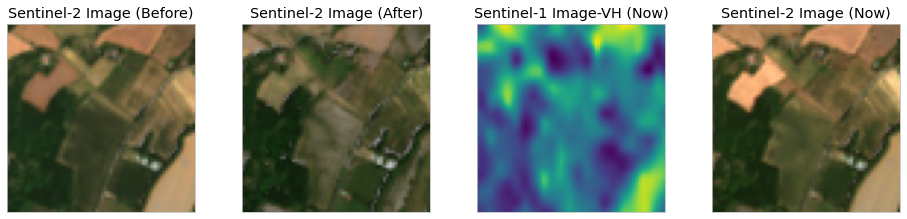

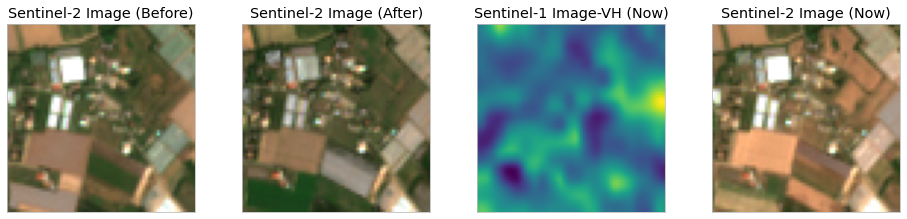

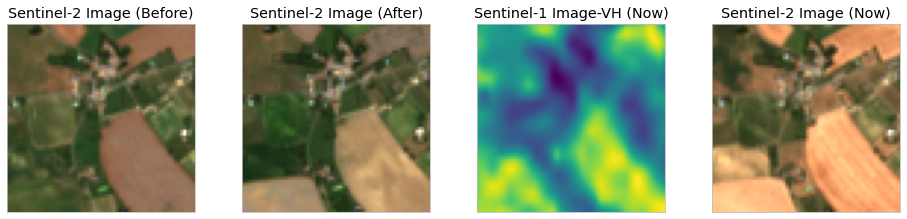

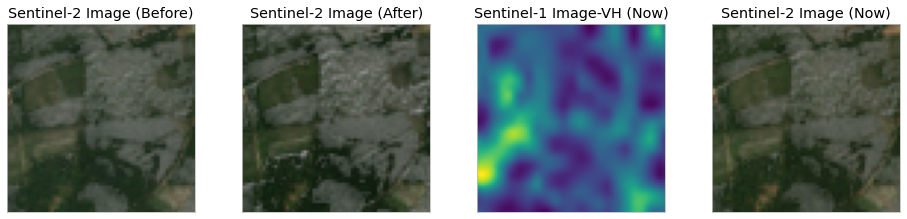

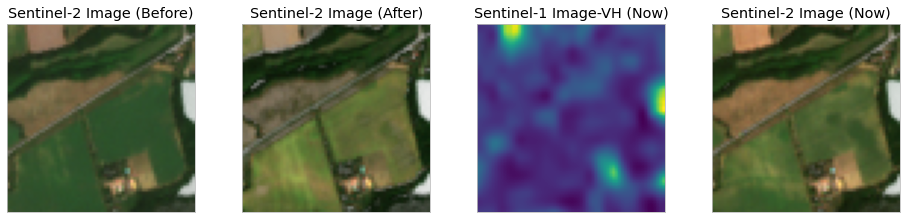

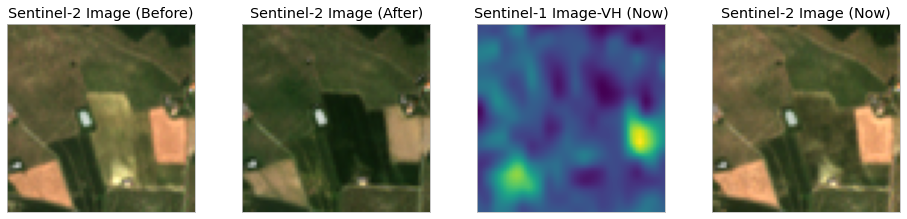

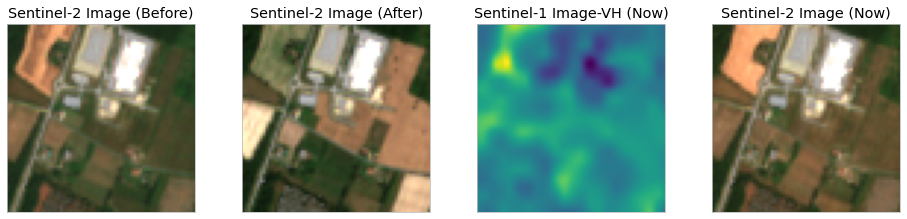

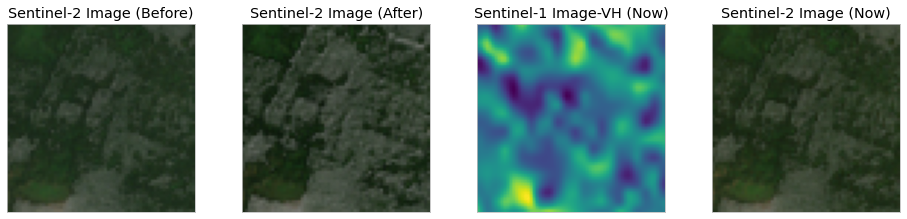

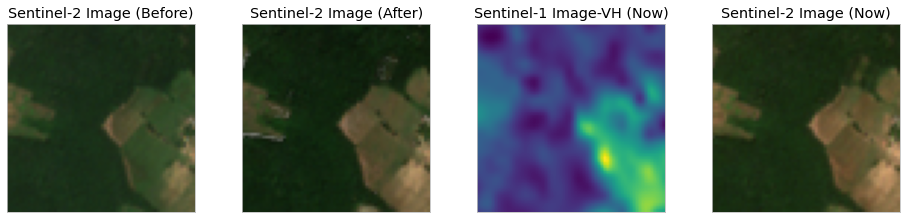

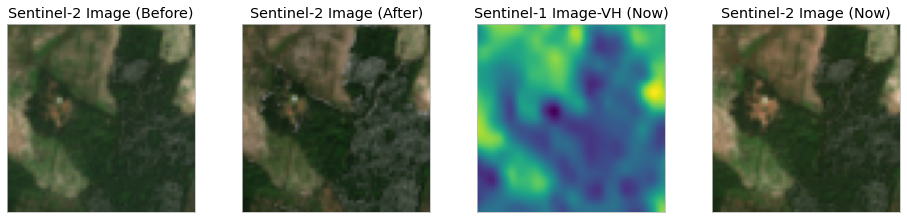

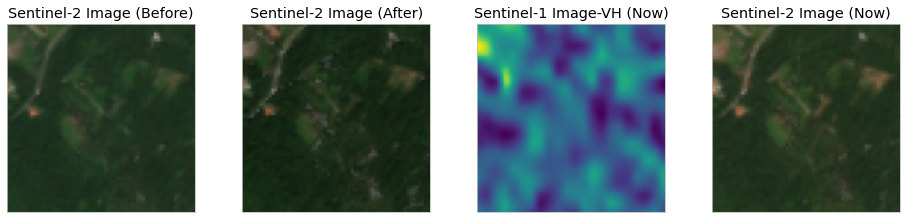

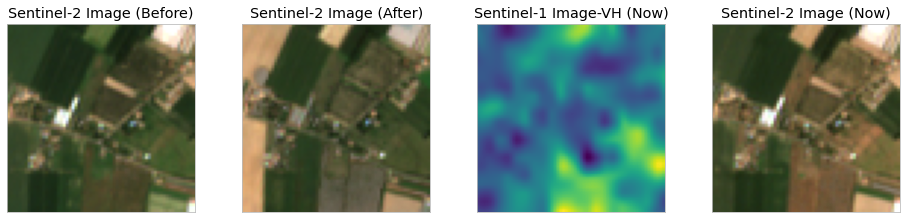

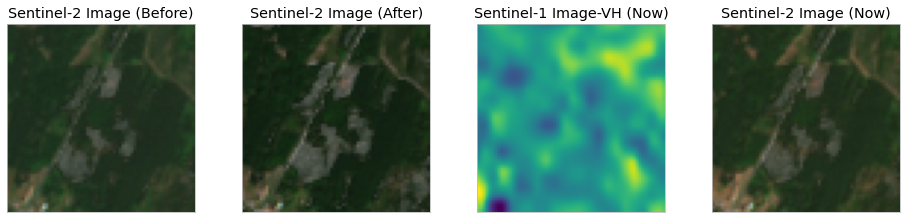

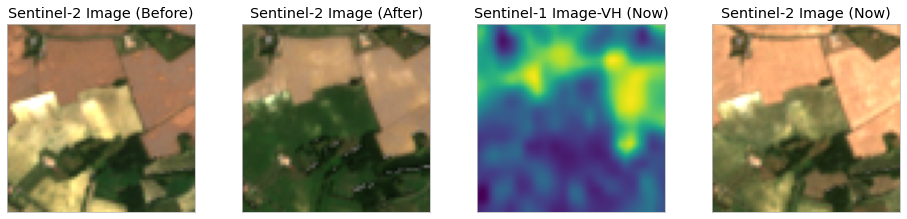

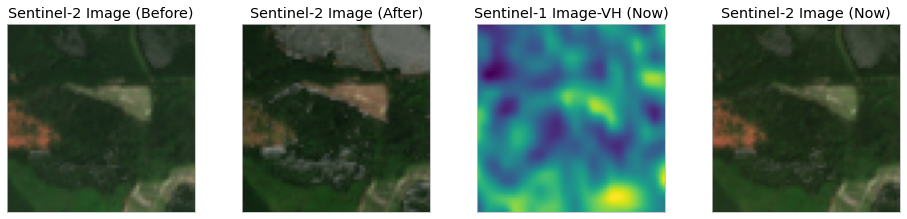

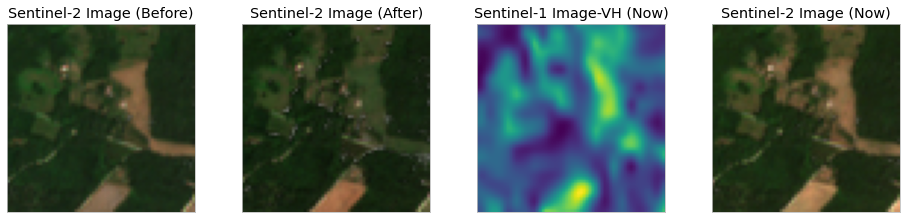

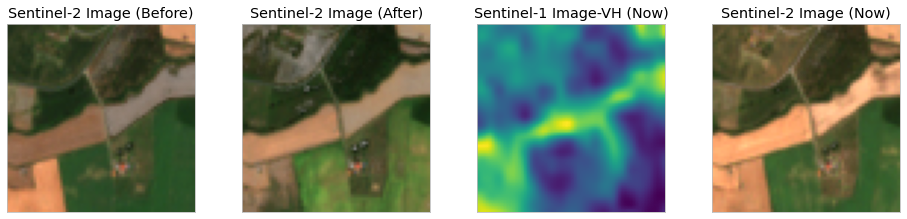

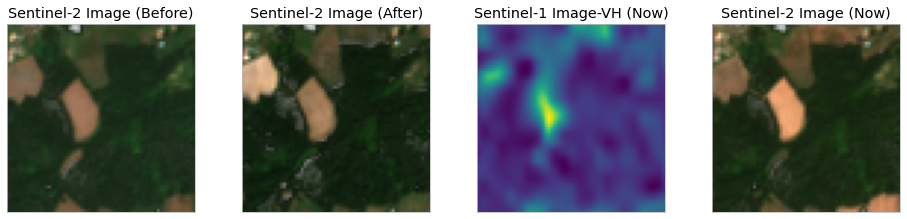

In [98]:
for i in sample(range(0, len(img)), 24):
    fig = plt.figure(1, figsize=([16, 12]))
    gs = plt.GridSpec(1,4, wspace=0.25, hspace=0.25)


    # Panel 01
    xtr_subsplot= fig.add_subplot(gs[:,:1])
    plt.title('Sentinel-2 Image (Before)')
    plt.imshow(np.clip(img[i][0]*3,0,1))   
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Panel 02
    xtr_subsplot= fig.add_subplot(gs[:,1:2])
    plt.title('Sentinel-2 Image (After)')
    plt.imshow(np.clip(img[i][1]*3,0,1))   
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Panel 03
    xtr_subsplot= fig.add_subplot(gs[:,2:3])
    plt.title('Sentinel-1 Image-VH (Now)')
    plt.imshow(np.clip(img[i][2][...,0],0,1))   
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)


    # Panel 04
    xtr_subsplot= fig.add_subplot(gs[:,3:])
    plt.title('Sentinel-2 Image (Now)')
    plt.imshow(np.clip(img[i][3]*3,0,1))   
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)


    plt.show()